## Importing Packages

In [1]:
# Importing (using/include) packages and files needed for the code to run 
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
using Dates
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")

# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Topography Setup

In [2]:
function initial_ice_depth(x::Float64)
    return 2.7e4
end 

function initial_surface_depth(x::Float64)
     return 0.0
end

function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/mol*K)
    ice_vis = (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e25
    lowerlimit = 1e12
    if ice_vis < lowerlimit
        ice_vis = lowerlimit
    elseif ice_vis > upperlimit
        ice_vis = upperlimit
    else 
        ice_vis = ice_vis
    end 
    return ice_vis
end

ice_viscosity (generic function with 1 method)

# Material Setup

In [3]:
struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([0.0,0.0],[1000.0,920.0],[0.0,0.0],[4180.0,2100.0],[0.5610,2.1],[1e12,1e15])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity(markers.scalars[T,i])
        end
    end
end

function update_marker_temp!(markers::Markers,materials::Materials)
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 1 
            markers.scalars[T,i] = 273.0
#         elseif mmat[i] == 3 
#             markers.scalars[T,i] = 100.0
        end 
    end 
end 

function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        hsurf = initial_surface_depth(mx)
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1] 
            markers.scalars[kThermal,i] = materials.kThermal[1]
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]
            markers.scalars[kThermal,i] = materials.kThermal[2]
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

initial_conditions! (generic function with 1 method)

# Model Setup

In [37]:
function run(;max_time::Float64,max_step::Int64)
    nx = 60
    ny = 59
    W = 90000.0
    H = 60000.0
    gx = 0.0
    gy = 1.3
    
    Tbctype = [1,-1,1,1] #left, right, top, bottom
    Tbcval = [273.0,0.0,75.0,273.0] #left, right, top, bottom
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr","kThermal"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)
    
    Tsurf = zeros(Float64,grid.nx)
    
    ### Setting up agruments for termination criteria ###
    max_time::Float64 = max_time == -1.0 ? typemax(Float64) : max_time
    max_step::Int64 = max_step == -1 ? typemax(Int64) : max_step
    
    time = 0.0
    iout= 0
    last_plot = 0.0
    dt = 1e10
    
    # Localaztion 
    local rho_c  
    local Cp_c 
    local Tlast 
    local kThermal
    local dTmax
    local dTemp
    local Tnew
    local R

    itime = 1
    output_dir = "test"
    
    local BoltzmannConstant = 5.67e-8 # W/m^2*K^4
    local qIn = (1)*(BoltzmannConstant)*(75.0) # W/m^2
    
    terminate = false
    while !terminate
        # 0. update the markers properties  
        update_marker_prop!(markers,materials)
        update_marker_temp!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic")
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new,kThermal_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr","kThermal"],"center")
        
        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(kThermal,kThermal_new)
        end
        
        # Copy field data 
        kThermal = copy(kThermal_new)
        rho_c = copy(rho_c_new)
        Cp_c = copy(Cp_c_new)
        Tlast = copy(Tlast_new)
        
        if itime == 1
            println(Tbctype,Tbcval)
            Tlast = ghost_temperature_center(grid,Tlast,Tbctype,Tbcval,Tsurf)
            cell_center_to_markers!(markers,grid,Tlast,"T")
        else
            Tlast = ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
        end
        
        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        
        
        # 1. Assume a T(x) at surface 
        # 2. Sovlve T(x,y)
        # 3. Compute q_surf 
        # 4. Update T 
        j = 1
        for j in 1:grid.x
            for titer=1:2
                println("Trying with timestep ",dt/seconds_in_year/1e3," kyr")
                L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval,Tsurf)
                Tnew = L\R;
                Tnew = reshape(Tnew,grid.ny,grid.nx);
                Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval,Tsurf)
                
                dTemp = Tnew-Tlast
                # compute the maximum temperature change
                dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]));
#                 println("dTmax=",dTmax," dt=",dt/seconds_in_year/1e3," kyr")
                dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
                if dTmax < 10.0
                    break
                end
                q_surf = (kThermal)*(Tlast[2,:] - Tlast[1,:])/(grid.y[2] - grid.y[1])
                R = q_surf - (BoltzmannConstant.*Tsurf.^4 .- qIn)
                dRdT = 4*BoltzmannConstant.*Tsurf.^3
                Tlast[j+1] = Tlast[j] - (R/dRdT)
            end
            j += 1 
        end

        # Checking Termination Criteria, time is in Myr
        if time >= max_time || itime >= max_step
            terminate = true
        end 
    end
    return grid,markers,rho_c,Tnew,seconds_in_year,R
end
@time grid,markers,rho_c,Tnew,seconds_in_year,R = run(max_time=-1.0,max_step=2)

figure()
scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
show()

Creating Markers...
  0.001030 seconds (19 allocations: 12.690 MiB)
Initial condition...
  0.024955 seconds (601.89 k allocations: 9.466 MiB)
[1, -1, 1, 1][273.0, 0.0, 75.0, 273.0]
assigning left boundary temperature 273.0


LoadError: MethodError: no method matching (::Colon)(::Int64, ::Vector{Float64})
[0mClosest candidates are:
[0m  (::Colon)(::T, ::Any, [91m::T[39m) where T<:Real at range.jl:41
[0m  (::Colon)(::A, ::Any, [91m::C[39m) where {A<:Real, C<:Real} at range.jl:10
[0m  (::Colon)(::T, ::Any, [91m::T[39m) where T at range.jl:40
[0m  ...

# Plot Profiles

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


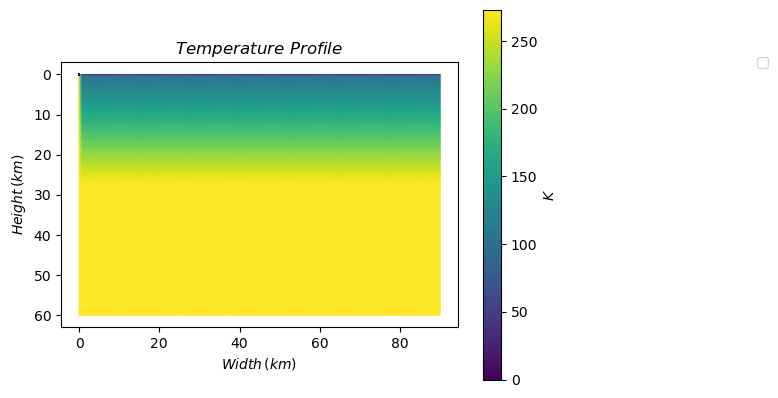

In [6]:

# Temperature Profile 
figure()
scatter(markers.x[1,:]/1000,markers.x[2,:]/1000,c=markers.scalars[markers.scalarFields["T"],:],s=0.1)
title(L"Temperature\,\,Profile")
colorbar(label=L"K")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(km)")
gca().set_xlabel(L"Width\,(km)")
legend(loc="center right",bbox_to_anchor=[1.8,1.0])
show()


LoadError: MethodError: no method matching getindex(::Nothing, ::Int64, ::Colon)